In [1]:
# using CuArrays # comment me out if you don't want to use GPU
using Flux, Flows
import Distributions: rand, logpdf
import PyPlot; const plt = PyPlot
using Tracker: update!

## Generate some data from a mixture of two Gaussians to use

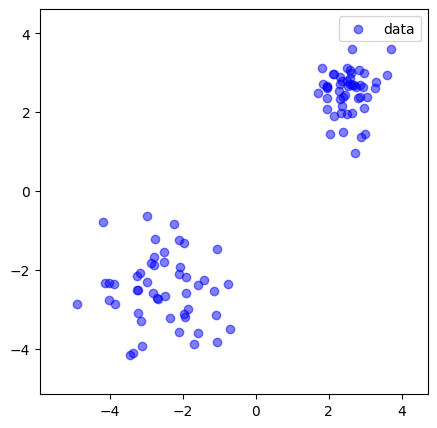

2×100 Array{Float32,2}:
 2.38712  2.68983  1.94246  2.37     …  -4.01833  -2.24863   -1.13907
 1.49809  2.67962  2.36052  2.15715     -2.32707  -0.838046  -2.52953

In [2]:
X = randn(Float32, 2, 100)
X[:,1:50] .*= 0.5
X[:,1:50] .+= 5.0
X .-= 2.5

function makeplot(x, xgen=nothing)
    p = plt.figure(figsize=(5, 5))
    plt.scatter(x[1,:], x[2,:], c="blue", alpha=0.5, label="data")
    xgen == nothing || plt.scatter(xgen[1,:], xgen[2,:], c="red", alpha=0.5, label="samples")
    plt.xlim([extrema(x[1,:])...] + [-1, 1])
    plt.ylim([extrema(x[2,:])...] + [-1, 1])
    plt.legend()
    nothing
end

makeplot(X)

# Send data to GPU
X = X |> gpu

## Create a normalising flow by stacking multiple affine coupling layers

$$ f = f_1 \circ f_2 \circ \cdots \circ f_{N-1} \circ f_N : \mathcal{Z} \rightarrow \mathcal{X}$$

We assume base distribution is the unit Gaussian, i.e. $p_{\mathcal{Z}} = \mathcal{N}(0,1)$.

In [3]:
# Define a base distribution that is easy to work with GPU
struct MvNormal01
    dim::Int
end

# The constant below is a hack to make things work on GPU.
const LOG2PI32 = log(2Float32(pi))
logpdf(d::MvNormal01, x) = sum(-(LOG2PI32 .+ x .* x) ./ 2; dims=1)
rand(d::MvNormal01, n::Int=1) = randn(Float32, d.dim, n) |> gpu

# Make a helper function to composing multiple transformations
function stack_affinecouplings(xdim, ntrans; nhiddens=1, hdim=xdim, actfunc=relu)
    ts = []
    mask = instantiate(AlternatingMasking(xdim)) |> gpu
    for _ in 1:ntrans
        f1 = Dense(xdim, hdim, actfunc) |> gpu
        f21 = Dense(hdim, xdim) |> gpu
        f22 = Dense(hdim, xdim) |> gpu
        t = AffineCoupling(Chain(f1, f21), Chain(f1, f22), mask)
        push!(ts, t)
        mask = 1 .- mask
    end
    return compose(ts...)
end

NLAYERS = 4
H = 20
T = stack_affinecouplings(size(X, 1), NLAYERS; hdim=H)
base = MvNormal01(size(X, 1))

# A normalising flow is nothing but a transformation plus a base distribution
# Check `src/flows.jl` for the abstraction
flow = Flow(T, base)

# Create optimiser
opt = ADAM(2e-3)
ps = params(flow)
;

## Define loss

$$\mathcal{L} = -\log p_{\mathcal{X}}(x) = -\log p_{\mathcal{Z}}(f^{-1}(x)) + \log \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|,$$

where $f^{-1}: \mathcal{X} \rightarrow \mathcal{Z}$.

In [4]:
compute_loss(x) = -sum(logpdf(flow, x)) / size(x, 2)

compute_loss (generic function with 1 method)

## Run optimisation

In [5]:
niters = 2_000

for iter = 1:niters
    print(".")
    loss = compute_loss(X)
    gs = Tracker.gradient(() -> loss, ps)
    update!(opt, ps, gs)
    if iter % 100 == 0 println("($iter/$niters) done; loss=$(Flux.data(loss))") end
end

....................................................................................................(100/2000) done; loss=66.0159
....................................................................................................(200/2000) done; loss=16.343603
....................................................................................................(300/2000) done; loss=12.3193655
....................................................................................................(400/2000) done; loss=11.768983
....................................................................................................(500/2000) done; loss=11.398868
....................................................................................................(600/2000) done; loss=11.165493
....................................................................................................(700/2000) done; loss=11.008057
.............................................................................

## Draw samples

$$ z \sim \mathcal{N}(0,1) $$
$$ x = f(z) $$

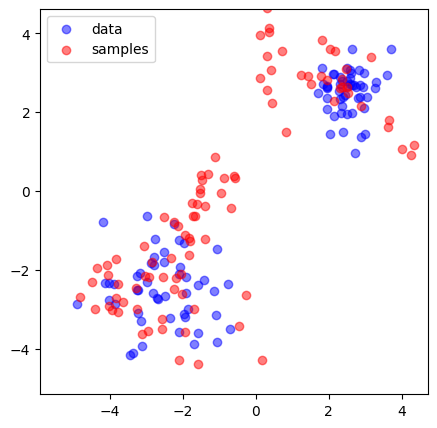

In [6]:
# Draw 100 samples from the normalising flow
Xgen = rand(flow, 100) |> cpu |> Flux.data

makeplot(X, Xgen)